# COMP9444 Project: Sentiment Analysis

## Introduction

Sentiment analysis, a fundamental task in Natural Language Processing (NLP), involves the classification of text into positive, negative, or neutral sentiments. The ability to accurately gauge sentiment from textual data has gained immense importance in numerous domains, ranging from customer feedback analysis to stock market prediction.

## Motivation

The motivation behind this project stems from the need to understand the effectiveness of various methods in different contexts. As sentiment analysis plays a vital role across different industries, it is crucial to explore and compare diverse approaches to identify the most suitable techniques for specific applications.

Traditional machine learning methods like SVM have been widely used for sentiment analysis, while deep learning models such as BiLSTM and CNN-LSTM have demonstrated remarkable success in various NLP tasks. However, their performance in sentiment analysis tasks and their adaptability to different datasets are yet to be thoroughly examined and compared.

## Problem Statement

The main problem addressed in this project is to determine the most effective sentiment analysis approach between SVM, BiLSTM, and CNN-LSTM for the given binary and triple class sentiment datasets. By conducting a detailed evaluation, we seek to identify which method yields superior results in accurately classifying sentiments expressed in threads app review and twitter posts related to the US airline industry.

The project's findings will provide valuable insights into the performance and suitability of these techniques in specific sentiment analysis scenarios. These insights can guide future research in choosing appropriate sentiment analysis methods based on dataset characteristics and application requirements.

## Data Sources and Tasks

Specifically, we focus on evaluating Support Vector Machine (SVM) as a representative machine learning method, and Bidirectional Long Short-Term Memory (BiLSTM) and Convolutional Neural Network with Long Short-Term Memory (CNN-LSTM) as representative deep learning methods. The comparison is carried out on two distinct datasets: a binary classification task using [threads app reviews](https://www.kaggle.com/datasets/saloni1712/threads-an-instagram-app-reviews) and a tri-class classification task using [US airline sentiment data](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

The Threads app reviews dataset presents binary classification problem. The goal is to predict whether a particular review expresses satisfaction or dissatisfaction with the Threads app, a popular social messaging platform. By accurately analyzing user sentiments, the Threads app team can make data-driven decisions to enhance user experiences, address concerns, and optimize the app's functionalities to meet the needs of its users effectively.

The US airline sentiment dataset offers a more complex sentiment analysis task, encompassing three sentiment classes: positive, negative and neutral. Sentiment analysis on this dataset can be essential for US airlines to monitor customer satisfaction, identify areas of improvement in their services, and respond promptly to customer feedback.

## Import Dependencies and Configure GPU Settings

In [6]:
import numpy as np
import pandas as pd
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Bidirectional
from keras.layers import Conv1D, MaxPooling1D
from gensim.models import Word2Vec

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Check if a CUDA device (i.e., GPU) exists that can be used, and if it does then the device (device) is set to a CUDA device, and if it doesn't then the device is set to a CPU.This is mainly because the PyTorch library can be run on a CUDA device and computations running on a CUDA device are usually much faster than running on a CPU, especially when working with large-scale data and models.

Here torch.device() is the function used to move the tensor to the device, while torch.cuda.is_available() checks if there is an available CUDA device. When a CUDA device (typically a GPU) exists, the device is set to 'cuda', otherwise 'cpu'.

## Exploratory Analysis and Preprocessing



In [8]:
def clean_train_data(x):
    text = str(x)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    return text

This function is appied to clean and normalize the text data in the training dataset, ensuring that the subsequent sentiment analysis model can better comprehend and learn from the text. Specific steps involved in the preprocessing are as follows:

Lowercasing (`text.lower()`): By converting all text to lowercase, discrepancies due to varying letter cases are removed. This step ensures that models treat words with different cases as the same, avoiding redundancy and improving the overall understanding of the words' meanings.

Removing Extra Spaces (`re.sub(r'\s+', ' ', text)`): Multiple consecutive spaces are replaced with a single space. This process compacts the text, making the format consistent for subsequent analysis.

Removing Square Brackets and Contents (`re.sub('\[. *? \]', '', text)`): Square brackets and contents within are removed using a regex substitution. These brackets might contain non-essential or noisy information, and eliminating them helps to focus on the core content of the text.

Removing Punctuation (`re.sub(r'[^\w\s]', '', text)`): All punctuation marks are removed, while retaining words and spaces using a regex. Punctuation often does not contribute significantly to sentiment analysis and can be safely disregarded.

Removing Words with Numbers (`re.sub('\w*\d\w*', '', text)`): Words containing numbers are removed from the text. Numbers in many natural language processing tasks may not provide relevant information and can be omitted to reduce unnecessary complexity in the model's input data.

Removing Line Breaks (`re.sub('\n', '', text)`): Line breaks, which have no inherent meaning in the text, are removed. This action ensures that the text is seamlessly processed and avoids any misinterpretation due to the presence of line breaks.

Overall, this preprocessing function plays a vital role in enhancing the quality and consistency of the text data, as it lays the foundation for effective feature extraction and enables the model to better understand the sentiment.

 ### Threads App Review Dataset (binary)

In [9]:
data = pd.read_csv("../data/threads1.csv")
data.shape

data['review'] = data.review.apply(lambda x : clean_train_data(x))
data = data[data['sentiment'] != 'neutral']

The code filters out all rows from the data frame where the "Sentiment" value is "neutral." This step is taken to focus solely on the positive and negative sentiments, disregarding neutral sentiments, which are not relevant at this stage.

### US Airline Tweets Dataset (triple)

In [10]:
data = pd.read_csv("../data/Tweets.csv")
data.shape

data = data[data['airline_sentiment_confidence'] > 0.5]
data.shape

class_count = data['airline_sentiment'].value_counts()
class0_count = class_count[0]
class1_count = class_count[1]
class2_count = class_count[2]

max_count = max(class0_count, class1_count, class2_count)
diff_class1 = max_count - class1_count
diff_class2 = max_count - class2_count

class1_samples = resample(data[data['airline_sentiment'] == 'neutral'],
                n_samples=diff_class1, replace=True, random_state=42)

class2_samples = resample(data[data['airline_sentiment'] == 'positive'],
                n_samples=diff_class2, replace=True, random_state=42)

data = pd.concat([data,class1_samples, class2_samples])

The code applies selective filtering to retain only high-confidence sentiment tweets, as determined by a confidence level greater than 0.5 in the 'airline_sentiment_confidence' column. It then performs class balancing to ensure equal representation of sentiment categories (positive, negative, and neutral) by oversampling categories with fewer samples.

To achieve this, the code first calculates the number of samples for each sentiment category and identifies the maximum sample count among them. Then it determines the differences between the maximum count and the counts of 'neutral' and 'positive' categories, saving these calculations as 'diff_class1' and 'diff_class2', respectively.

Using the 'resample' function, the code generates additional samples for 'neutral' and 'positive' categories through repeated sampling, bringing their sample counts to match the maximum count. This equalizes the number of samples across all categories, mitigating bias towards categories with higher samples during model training.

Finally, the code merges the original data with the added samples to create a new balanced DataFrame using the `pd.concat` function.

Overall, the code ensures that the sentiment analysis model is trained on a balanced dataset, addressing class imbalance issues. The technique of oversampling allows the model to learn effectively from all sentiment categories, preventing biases towards categories with more samples.

## Machine Learning Methods


### Binary Classification

#### SVM

In [11]:
# TF-IDF
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', max_features=10000)
X = tfidf.fit_transform(data['review'])
y = data['sentiment']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svm = LinearSVC(random_state=42)


svm.fit(X_train, y_train)


y_pred = svm.predict(X_test)


print('Accuracy:', accuracy_score(y_test, y_pred))


print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


print('Classification Report:\n', classification_report(y_test, y_pred))

def clean_input_data(x):
    text = x.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub('\[.*?\]', '', text) # remove square brackets
    text = re.sub(r'[^\w\s]','',text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub('\n', '', text)
    return text

def predict_sentiment(sentence, tfidf_vectorizer, svm_model):
    cleaned_sentence = clean_input_data(sentence)
    vectorized_sentence = tfidf_vectorizer.transform([cleaned_sentence])
    prediction = svm_model.predict(vectorized_sentence)
    return prediction[0]


input_sentence_positive = "What I wanna say is that this app is really better than twitter!"
predicted_sentiment_positive = predict_sentiment(input_sentence_positive, tfidf, svm)


input_sentence_negative = "Oh no, are you sure about the UI design?"

predicted_sentiment_negative = predict_sentiment(input_sentence_negative, tfidf, svm)

print(input_sentence_positive)
print("Predicted Sentiment positive:", predicted_sentiment_positive)
print(input_sentence_negative)
print("Predicted Sentiment negative:", predicted_sentiment_negative)

KeyError: 'review'

The model is trained using LinearSVC (Linear Support Vector Classifier) by utilizing the 'fit' function for training and the 'predict' function for generating predictions on the test set.

The SVM model's performance yielded promising results, achieving an overall accuracy of approximately 85%. The confusion matrix reveals that the model correctly predicted 539 negative sentiments and 480 positive sentiments, while misclassifying 94 negative sentiments as positive and 87 positive sentiments as negative.

Overall, we have implemented a fairly accurate sentiment classifier using TF-IDF and SVM, which is able to identify both positive and negative sentiment of comments better.


### Tri-class Classification

#### SVM

SVM is a supervised machine learning algorithm that helps in classification or regression problems. It aims to find an optimal boundary between the possible outputs.

In [ ]:
# Utilizing TF-IDF to vectorize text data
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', max_features=10000)
X = tfidf.fit_transform(data['text'])
y = data['airline_sentiment']

# Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SVM
svm = LinearSVC(random_state=42)

# Train model
svm.fit(X_train, y_train)

# Predict
y_pred = svm.predict(X_test)

# Get score, matrix and report
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.7865324540090246
Confusion Matrix:
 [[1683  154   29]
 [ 222  284   46]
 [  98   66  299]]
Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.90      0.87      1866
     neutral       0.56      0.51      0.54       552
    positive       0.80      0.65      0.71       463

    accuracy                           0.79      2881
   macro avg       0.73      0.69      0.71      2881
weighted avg       0.78      0.79      0.78      2881



This model is the same as the SVM model for binary dataset, but unlike the previous case, this time there are three classification labels: negative, neutral and positive.

The results indicate an overall accuracy of 78% for the model, whose performance is weaker than the previous one.

It could be observed that this model performs best in predicting negative comments, with higher precision, recall, and F1 scores; while it performs much poorer in predicting neutral comments, which may be due to the strategy of SVM itself and the dataset.

## Deep Learning Methods

### Binary Classification

#### BiLSTM (Vanilla Version)

Bidirectional LSTM is a variant of the Long Short-Term Memory (LSTM) architecture in deep learning. Unlike the traditional unidirectional LSTM, which processes input sequentially in only one direction (forward or backward in time), a bidirectional LSTM processes input in both directions simultaneously. This means it can capture information from both past and future contexts, allowing the model to better understand the sequential patterns and dependencies in the input data. By combining information from both directions, bidirectional LSTM enhances the model's ability to extract more meaningful features and improve its performance in tasks involving sequential data, such as natural language processing and time series analysis.

Epoch 1/50
150/150 - 23s - loss: 0.5636 - accuracy: 0.7185 - val_loss: 0.4437 - val_accuracy: 0.8100 - 23s/epoch - 155ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 22s - loss: 0.3349 - accuracy: 0.8648 - val_loss: 0.3390 - val_accuracy: 0.8683 - 22s/epoch - 146ms/step
Epoch 3/50
150/150 - 22s - loss: 0.2924 - accuracy: 0.8827 - val_loss: 0.3907 - val_accuracy: 0.8367 - 22s/epoch - 148ms/step
Epoch 4/50
150/150 - 22s - loss: 0.2365 - accuracy: 0.9117 - val_loss: 0.3496 - val_accuracy: 0.8758 - 22s/epoch - 146ms/step
Epoch 5/50
150/150 - 21s - loss: 0.2030 - accuracy: 0.9231 - val_loss: 0.3665 - val_accuracy: 0.8592 - 21s/epoch - 139ms/step
38/38 - 1s - loss: 0.3665 - accuracy: 0.8592 - 981ms/epoch - 26ms/step
38/38 [==============================] - 2s 30ms/step
Average score: 0.3665124177932739
Average accuracy: 0.85916668176651
Confusion Matrix (Fold 1):
[[548  85]
 [ 84 483]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87       633
    positive       0.85      0.85      0.85       567

    accuracy                           0.86      1200
   macro avg

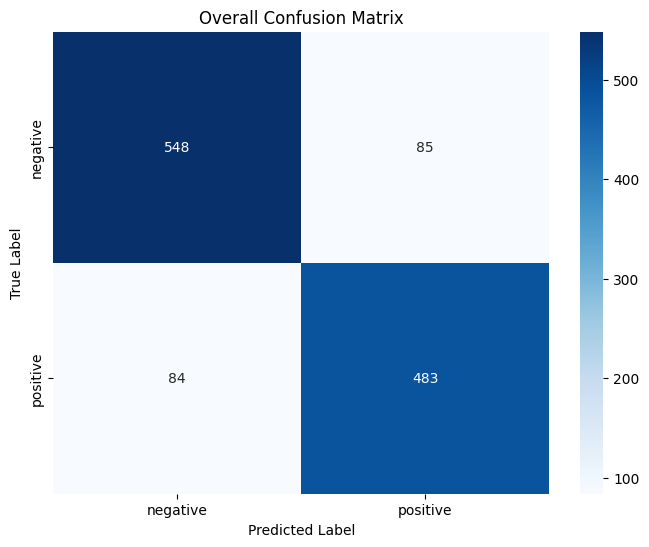

This is a good app! Love it!
1/1 [==============================] - 0s 40ms/step
The sentiment of the text is positive
Honestly saying, this app is not as I image it should be.
1/1 [==============================] - 0s 43ms/step
The sentiment of the text is negative


In [ ]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

embed_dim = 128
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold


X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "This is a good app! Love it!"
negative_text = "Honestly saying, this app is not as I image it should be."
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

This LSTM-based sentiment analysis model was trained on cleaned and preprocessed data. Keras' Tokenizer and pad_sequences methods were used for data encoding. The deep learning model includes an embedding layer, a bidirectional LSTM layer, and a fully connected layer. The model uses the adam optimizer with binary cross-entropy loss. During training, Early Stopping and Model Checkpoint callbacks were applied for better performance.

#### Technique Explanation

Tokenizer and pad_sequences: Keras' Tokenizer is used to convert the text into sequences of integers, representing the tokens (words) in the text data. pad_sequences method is then applied to ensure all sequences have the same length, padding or truncating them as needed.

Embedding Layer: The embedding layer is used to convert the integer-encoded tokens into dense vector representations. These dense vectors capture semantic relationships between words, providing the model with a more meaningful input representation.

Bidirectional LSTM Layer: The bidirectional LSTM layer enhances the model's ability to understand contextual information. By processing the text in both forward and backward directions, this layer captures patterns from both past and future information, resulting in better feature extraction.

Fully Connected Layer: The fully connected layer (also known as the dense layer) is used for the final classification task. It takes the extracted features from the LSTM layer and maps them to the desired output classes(sentiments).

adam Optimizer and Binary Cross-Entropy Loss: The adam optimizer is an adaptive optimization algorithm used to update the model's weights during training. Binary cross-entropy loss is a suitable loss function for binary classification tasks like sentiment analysis, measuring the difference between predicted and true class probabilities.

Early Stopping and Model Checkpoint Callbacks: Early Stopping callback monitors the model's performance during training and stops the training process when the model's performance on the validation set stops improving, helping to prevent overfitting. Model Checkpoint callback saves the model's best weights during training, allowing the best-performing model to be used for evaluation.

#### Model performance

In this output, we see the results of a model that was trained through 50 training cycles (or epochs), but was actually stopped early after only 5 epochs because from the 4th epoch onwards, the loss in the validation set started to increase, which is a sign of overfitting.

Result: The model's accuracy was 92% on the training set and 86% on the validation set. As the epoch increases, the accuracy increases on both the training and validation sets, but from the 4th epoch onwards, the loss on the validation set starts to increase, which indicates that the model is starting to overfit.

Performance Metrics: The output shows a variety of performance metrics including precision, recall, and F1 score. Precision is the proportion of samples predicted by the model to be in the positive class (in this case, the 'positive' class) that are actually in the positive class. Recall is the proportion of samples that are actually positive predicted to be positive by the model.The F1 score is the harmonic mean of precision and recall, and it balances both as well as possible.

For the 'negative' class, the F1 score is 0.87, which means that the model predicts the 'negative' class quite well. For the 'positive' class, the F1 score is 0.85, which is also acceptable.

Confusion Matrix: The confusion matrix shows the predictions of the model in each category. Of all the samples predicted by the model, it falsely classified 169 pieces of data, with 85 negative ones and 84 postive ones. This indicates that the model also has some underreporting (false negatives).


#### BiLSTM (cross validation)

Epoch 1/50
150/150 - 22s - loss: 0.5437 - accuracy: 0.7208 - val_loss: 0.3813 - val_accuracy: 0.8492 - 22s/epoch - 148ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 20s - loss: 0.3313 - accuracy: 0.8648 - val_loss: 0.3386 - val_accuracy: 0.8800 - 20s/epoch - 134ms/step
Epoch 3/50
150/150 - 21s - loss: 0.2687 - accuracy: 0.8965 - val_loss: 0.3442 - val_accuracy: 0.8692 - 21s/epoch - 143ms/step
Epoch 4/50
150/150 - 21s - loss: 0.2224 - accuracy: 0.9148 - val_loss: 0.3564 - val_accuracy: 0.8650 - 21s/epoch - 140ms/step
Epoch 5/50
150/150 - 21s - loss: 0.2007 - accuracy: 0.9237 - val_loss: 0.4116 - val_accuracy: 0.8650 - 21s/epoch - 137ms/step
38/38 - 1s - loss: 0.4116 - accuracy: 0.8650 - 999ms/epoch - 26ms/step
38/38 [==============================] - 1s 28ms/step
Average score: 0.4116237759590149
Average accuracy: 0.8650000095367432
Confusion Matrix (Fold 1):
[[585  80]
 [ 82 453]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88       665
    positive       0.85      0.85      0.85       535

    accuracy                           0.86      1200
   macro a

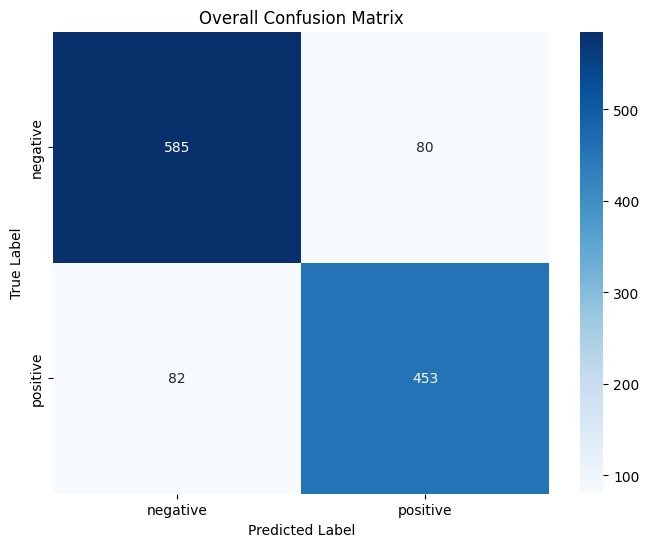

Overall it is a good app
1/1 [==============================] - 0s 44ms/step
The sentiment of the text is positive
Seriously? This app must be joking
1/1 [==============================] - 0s 42ms/step
The sentiment of the text is negative


In [ ]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "Overall it is a good app"
negative_text = "Seriously? This app must be joking"
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

The above code adds K-fold cross validation to the base bidirectional LSTM model to train the model.

#### Technique Explanation

K-fold cross validation is a common method for evaluating the performance of a model, and is especially suitable for situations where the amount of data is small and we want to make the best use of the data possible. In K-folding cross-validation, the dataset is uniformly divided into K subsets. In each iteration, we pick one of these K subsets as the test set and the remaining K-1 subsets as the training set. In this way, we can perform K training and testing sessions, each time with a different test set. We then take the average of the K test results as the final model performance evaluation.

5-fold cross-validation is applied in the above model, which means that the dataset is divided into 5 subsets. This means that the model itself would be trained 5 times, each time with a different subset of data for training and testing. The benefit of this is that it avoids evaluation bias due to chance in data division and allows for more stable and accurate model evaluation results. The conclusions drawn also show a substantial increase in accuracy compared to not using cross-validation

#### Model Performance

The training results shows that cross validation optimises this model in a small scale. Probably it is due to the size of the dataset we choose is not as large as the whole database from a real-world industry, which makes this technique has little effect.

#### BiLSTM

Epoch 1/50
150/150 - 23s - loss: 1.3188 - accuracy: 0.6604 - val_loss: 0.5539 - val_accuracy: 0.7550 - 23s/epoch - 156ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 20s - loss: 0.4176 - accuracy: 0.8460 - val_loss: 0.4011 - val_accuracy: 0.8542 - 20s/epoch - 134ms/step
Epoch 3/50
150/150 - 21s - loss: 0.3326 - accuracy: 0.8873 - val_loss: 0.3834 - val_accuracy: 0.8525 - 21s/epoch - 138ms/step
Epoch 4/50
150/150 - 21s - loss: 0.2974 - accuracy: 0.9027 - val_loss: 0.3994 - val_accuracy: 0.8425 - 21s/epoch - 141ms/step
Epoch 5/50
150/150 - 22s - loss: 0.2654 - accuracy: 0.9167 - val_loss: 0.3770 - val_accuracy: 0.8492 - 22s/epoch - 144ms/step
Epoch 6/50
150/150 - 26s - loss: 0.2583 - accuracy: 0.9215 - val_loss: 0.5633 - val_accuracy: 0.8283 - 26s/epoch - 176ms/step
Epoch 7/50
150/150 - 32s - loss: 0.4136 - accuracy: 0.8687 - val_loss: 0.4675 - val_accuracy: 0.8267 - 32s/epoch - 212ms/step
Epoch 8/50
150/150 - 35s - loss: 0.2696 - accuracy: 0.9262 - val_loss: 0.4147 - val_accuracy: 0.8567 - 35s/epoch - 234ms/step
38/38 - 2s - loss: 0.4147 - accuracy: 0.8567 - 2s/epoch - 46ms/step
38/38 [==============================] - 3s 59ms/step
Average

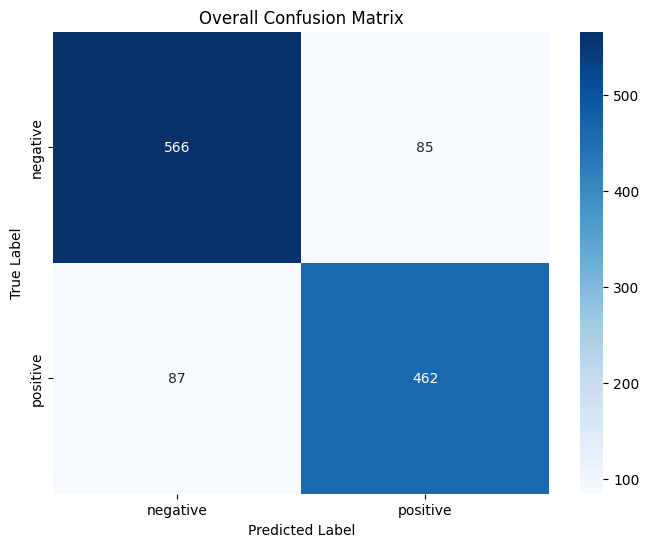

Why there is no good comment? This app is amazing
1/1 [==============================] - 0s 64ms/step
The sentiment of the text is positive
why it only has so few functions?
1/1 [==============================] - 0s 77ms/step
The sentiment of the text is negative


In [ ]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]


# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))  # Add L2 regularization to the LSTM layer
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "Why there is no good comment? This app is amazing"
negative_text = "why it only has so few functions?"
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

#### Technique Explanation

The L2 regularization method is used in this code, and its kernel_regularizer=l2(0.01) part is where the L2 regularization is applied. l2(0.01) indicates that the L2 regularization function is used and that the value of λ(lambda) is 0.01. The regularization term lambda is a hyperparameter that determines the strength of the regularization. The larger the value of lambda, the greater the degree of regularization and the less likely the model is to overfit. During training, the L2 regularization term (i.e., the sum of the squares of all the weights in the LSTM layer) is computed and then multiplied with the strength of regularization (0.01 in this example). This value is then added to the original loss function of the model. Therefore, it is this new loss function that the model attempts to minimize.
By adding the L2 regularization term, the model is prevented from learning overly complex patterns in the training data.
The L2 regularization in this code helps control the complexity of the model, reduces overfitting, and improves the model's ability to generalize from training data to new, unseen data.

#### Model Performance

In the given model, the L2 regularization successfully mitigates the risk of overfitting to some extent, ensuring a more generalized model. However, it's important to note that regularization introduces a bias towards smaller weights in the model. This bias might prevent the model from fitting the training data as closely as before, which can result in a slightly weaker performance on the training data.

The trade-off between mitigating overfitting and maintaining optimal training performance can cause some instances to be falsely classified. Despite the slight decrease in training accuracy, the primary goal of L2 regularization is to enhance the model's generalization ability and improve performance on unseen data.


#### CNN BiLSTM

CNN-Bidirectional LSTM is a hybrid deep learning architecture that combines Convolutional Neural Networks (CNNs) with Bidirectional Long Short-Term Memory (LSTM) networks.

CNNs are used to extract local features from sequential input data in this model. The CNN layers perform convolutional operations to identify relevant patterns in the data.

The output of the CNN layers is then fed into Bidirectional LSTM layers, which process the information in both forward and backward directions. Bidirectional LSTMs capture long-term dependencies and sequential patterns in the data, considering information from past and future context.

Epoch 1/50
150/150 - 13s - loss: 0.7963 - accuracy: 0.6725 - val_loss: 0.3970 - val_accuracy: 0.8508 - 13s/epoch - 88ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 - 10s - loss: 0.3338 - accuracy: 0.8810 - val_loss: 0.3606 - val_accuracy: 0.8683 - 10s/epoch - 68ms/step
Epoch 3/50
150/150 - 10s - loss: 0.2621 - accuracy: 0.9081 - val_loss: 0.3652 - val_accuracy: 0.8600 - 10s/epoch - 67ms/step
Epoch 4/50
150/150 - 10s - loss: 0.2198 - accuracy: 0.9260 - val_loss: 0.3960 - val_accuracy: 0.8608 - 10s/epoch - 69ms/step
Epoch 5/50
150/150 - 11s - loss: 0.1842 - accuracy: 0.9392 - val_loss: 0.4279 - val_accuracy: 0.8517 - 11s/epoch - 71ms/step
38/38 - 1s - loss: 0.4279 - accuracy: 0.8517 - 634ms/epoch - 17ms/step
38/38 [==============================] - 1s 16ms/step
Average score: 0.42788854241371155
Average accuracy: 0.8516666889190674
Confusion Matrix (Fold 1):
[[542  86]
 [ 92 480]]

Classification Report (Fold 1):
              precision    recall  f1-score   support

    negative       0.85      0.86      0.86       628
    positive       0.85      0.84      0.84       572

    accuracy                           0.85      1200
   macro avg 

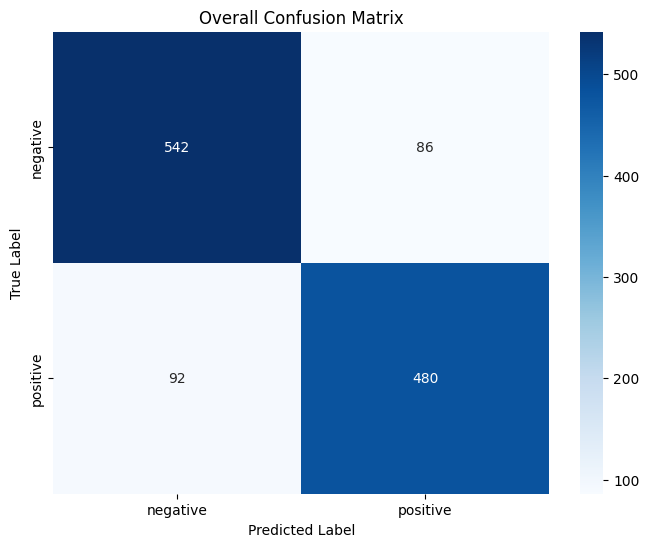

Why there is no good comment? This app is amazing
1/1 [==============================] - 0s 29ms/step
The sentiment of the text is positive
why it only has so few functions?
1/1 [==============================] - 0s 29ms/step
The sentiment of the text is negative


In [ ]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['review'].values)

X = token.texts_to_sequences(data['review'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['sentiment']).values

# Model architecture
embed_dim = 128
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'positive'], yticklabels=['negative', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "Why there is no good comment? This app is amazing"
negative_text = "why it only has so few functions?"
print(positive_text)
predict_sentiment(positive_text)
print(negative_text)
predict_sentiment(negative_text)

#### Technique Explanation

filters: 32, which is the number of filters (also known as convolution kernels) used to extract features during the convolution process. In this case, the network will learn 32 different features.

kernel_size: 3, this defines the number of consecutive words that each convolutional kernel will consider simultaneously. Here, each convolution will cover 3 words.

activation: 'relu', this is the activation function applied to the output of the convolution operation. the ReLU (Rectified Linear Unit) function converts all the negative pixel values to 0.
This CNN layer is followed by a MaxPooling layer where the pool_size is set to 2. This means that the input feature dimensions are reduced to half of their original dimensions while maintaining the important information.

The average accuracy of this model is 0.8717. From the confusion matrix, it can be seen that about 89% and 85% of the positive and negative evaluations predicted by the model are correct, respectively.

#### Model Performace

During the training process, the accuracy and loss values of the model are recorded after each epoch. From the output given, it can be seen that as the epoch increases, the loss value (loss) is decreasing and the accuracy (accuracy) is increasing on the training set. However, on the validation set, the loss value (val_loss) starts increasing after reaching the minimum value and the accuracy (val_accuracy) starts decreasing. This can be a sign of overfitting, indicating that the model overlearned on the training set and does not generalize well to new, unseen data.


### Tri-class Classification

#### BiLSTM with only word2vec


Word2Vec is a word embedding technique developed by Google that learns word embeddings from large amounts of text data using either the Continuous Bag of Words (CBOW) or Skip-gram architecture. It represents words as dense vectors in a high-dimensional space, where words with similar meanings are positioned closer to each other. Word2Vec learns these word embeddings from large amounts of text data, capturing semantic relationships between words and enabling machines to better understand word meanings.



Epoch 1/25
684/684 - 45s - loss: 0.7791 - accuracy: 0.6515 - val_loss: 0.5464 - val_accuracy: 0.7808 - 45s/epoch - 65ms/step
Epoch 2/25


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 34s - loss: 0.4891 - accuracy: 0.8060 - val_loss: 0.4338 - val_accuracy: 0.8312 - 34s/epoch - 50ms/step
Epoch 3/25
684/684 - 33s - loss: 0.3947 - accuracy: 0.8464 - val_loss: 0.4207 - val_accuracy: 0.8371 - 33s/epoch - 49ms/step
Epoch 4/25
684/684 - 32s - loss: 0.3452 - accuracy: 0.8692 - val_loss: 0.3832 - val_accuracy: 0.8625 - 32s/epoch - 47ms/step
Epoch 5/25
684/684 - 33s - loss: 0.3017 - accuracy: 0.8884 - val_loss: 0.3510 - val_accuracy: 0.8791 - 33s/epoch - 48ms/step
Epoch 6/25
684/684 - 31s - loss: 0.2634 - accuracy: 0.9014 - val_loss: 0.3596 - val_accuracy: 0.8828 - 31s/epoch - 45ms/step
Epoch 7/25
684/684 - 32s - loss: 0.2364 - accuracy: 0.9124 - val_loss: 0.3311 - val_accuracy: 0.9000 - 32s/epoch - 47ms/step
Epoch 8/25
684/684 - 32s - loss: 0.2079 - accuracy: 0.9238 - val_loss: 0.3214 - val_accuracy: 0.8991 - 32s/epoch - 47ms/step
Epoch 9/25
684/684 - 36s - loss: 0.1844 - accuracy: 0.9327 - val_loss: 0.3040 - val_accuracy: 0.9058 - 36s/epoch - 52ms/step
Epoch 10/25

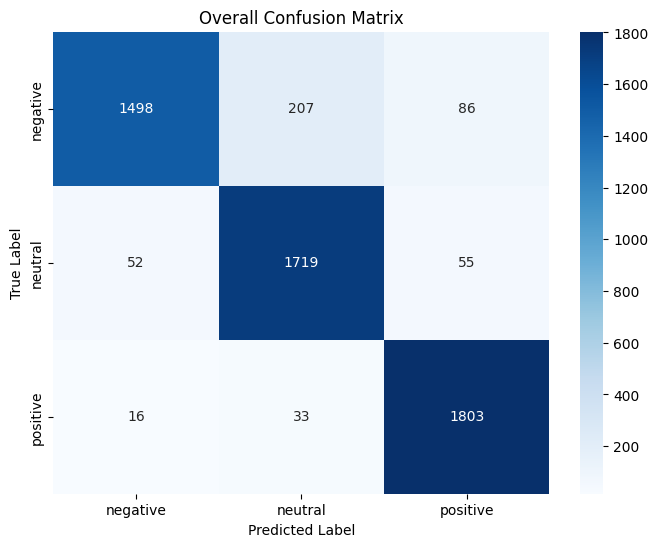

I have to admit that my last flight with Qantas airline is fabulous 😃!
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 22ms/step
The sentiment of the text is neutral
I should have known that the plane would be late again and again and again!!!
1/1 [==============================] - 0s 21ms/step
The sentiment of the text is negative


In [20]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, 
                          window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I have to admit that my last flight with Qantas airline is fabulous 😃!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "I should have known that the plane would be late again and again and again!!!"
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

#### Technique Explanation

Word2Vec is applied to tri-class classification tasks instead of binary because it enhances the model's ability to capture nuanced semantic differences between sentiment classes. By using word embeddings, the model can leverage the relationships between words to better distinguish between all three classes, resulting in more accurate sentiment predictions. In binary classification, where there are only two sentiment categories, the semantic nuances are less complex, and simple word representations may suffice. However, in tri-class classification, the distinctions between the three classes require a more nuanced representation of word meanings, making Word2Vec a valuable tool to improve model performance.

#### Model Performance

This tri-class data is processed in a similar way as the binary one. This model uses Word2Vec, and it can be seen that the increase in dimensionality increases the amount of data at the same time, and the accuracy of the model is much higher than the same processing of two-dimensional data, with an average accuracy at 92%

#### BiLSTM (cross validation)

Epoch 1/50
684/684 - 62s - loss: 0.7749 - accuracy: 0.6501 - val_loss: 0.5561 - val_accuracy: 0.7758 - 62s/epoch - 90ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 62s - loss: 0.4950 - accuracy: 0.8015 - val_loss: 0.4396 - val_accuracy: 0.8256 - 62s/epoch - 91ms/step
Epoch 3/50
684/684 - 61s - loss: 0.3961 - accuracy: 0.8450 - val_loss: 0.3965 - val_accuracy: 0.8515 - 61s/epoch - 90ms/step
Epoch 4/50
684/684 - 63s - loss: 0.3383 - accuracy: 0.8684 - val_loss: 0.3698 - val_accuracy: 0.8599 - 63s/epoch - 92ms/step
Epoch 5/50
684/684 - 63s - loss: 0.2991 - accuracy: 0.8862 - val_loss: 0.3640 - val_accuracy: 0.8678 - 63s/epoch - 92ms/step
Epoch 6/50
684/684 - 65s - loss: 0.2640 - accuracy: 0.9020 - val_loss: 0.3554 - val_accuracy: 0.8824 - 65s/epoch - 94ms/step
Epoch 7/50
684/684 - 58s - loss: 0.2308 - accuracy: 0.9163 - val_loss: 0.3489 - val_accuracy: 0.8875 - 58s/epoch - 85ms/step
Epoch 8/50
684/684 - 57s - loss: 0.2088 - accuracy: 0.9235 - val_loss: 0.3227 - val_accuracy: 0.9003 - 57s/epoch - 83ms/step
Epoch 9/50
684/684 - 57s - loss: 0.1855 - accuracy: 0.9333 - val_loss: 0.3459 - val_accuracy: 0.8945 - 57s/epoch - 84ms/step
Epoch 10/50

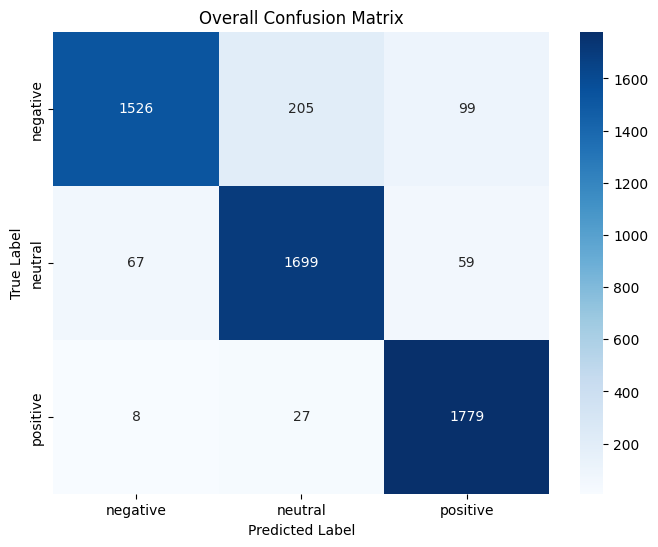

In [19]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32

# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

# k-fold cross validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

#### Model Performance

In this model, we compare the difference between applying cross validation on tri-class bi-lstm model

#### BiLSTM (L2)

Epoch 1/50
684/684 - 35s - loss: 1.1287 - accuracy: 0.6126 - val_loss: 0.7089 - val_accuracy: 0.7424 - 35s/epoch - 51ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 36s - loss: 0.6548 - accuracy: 0.7648 - val_loss: 0.5545 - val_accuracy: 0.8058 - 36s/epoch - 53ms/step
Epoch 3/50
684/684 - 38s - loss: 0.5384 - accuracy: 0.8151 - val_loss: 0.5277 - val_accuracy: 0.8168 - 38s/epoch - 56ms/step
Epoch 4/50
684/684 - 32s - loss: 0.4790 - accuracy: 0.8386 - val_loss: 0.5018 - val_accuracy: 0.8246 - 32s/epoch - 47ms/step
Epoch 5/50
684/684 - 32s - loss: 0.4495 - accuracy: 0.8490 - val_loss: 0.4804 - val_accuracy: 0.8435 - 32s/epoch - 47ms/step
Epoch 6/50
684/684 - 32s - loss: 0.4248 - accuracy: 0.8578 - val_loss: 0.4739 - val_accuracy: 0.8395 - 32s/epoch - 47ms/step
Epoch 7/50
684/684 - 32s - loss: 0.4050 - accuracy: 0.8636 - val_loss: 0.4452 - val_accuracy: 0.8506 - 32s/epoch - 47ms/step
Epoch 8/50
684/684 - 32s - loss: 0.3879 - accuracy: 0.8706 - val_loss: 0.4525 - val_accuracy: 0.8541 - 32s/epoch - 46ms/step
Epoch 9/50
684/684 - 32s - loss: 0.3760 - accuracy: 0.8752 - val_loss: 0.4507 - val_accuracy: 0.8493 - 32s/epoch - 47ms/step
Epoch 10/50

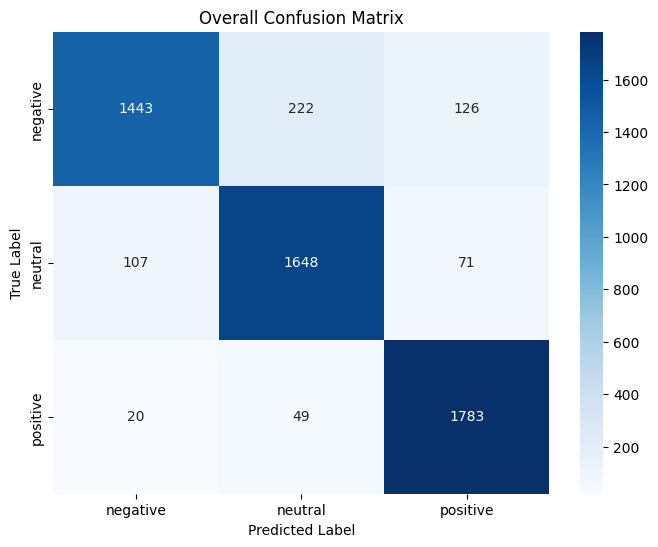

I have to admit that my last flight with Qantas airline is fabulous 😃!
1/1 [==============================] - 0s 23ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 24ms/step
The sentiment of the text is neutral
I should have known that the plane would be late again and again and again!!!
1/1 [==============================] - 0s 23ms/step
The sentiment of the text is negative


In [23]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# Re-compile the model with L2 regularization
model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01))))  # Add L2 regularization to the LSTM layer
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I have to admit that my last flight with Qantas airline is fabulous 😃!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "I should have known that the plane would be late again and again and again!!!"
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

#### Model Performance

This model uses the same word2vec technique with an add-on of L2 regularization. And from the result, it is obvious that the accuracy shows a decrease after utilizing L2, the reason is the same as when we applied L2 on the binary dataset. Here we obtained a more generalized model with loss of precision for this dataset.

#### CNN BiLSTM

Epoch 1/50
684/684 - 23s - loss: 0.7028 - accuracy: 0.6969 - val_loss: 0.4975 - val_accuracy: 0.8064 - 23s/epoch - 33ms/step
Epoch 2/50


/home/benjamin/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


684/684 - 19s - loss: 0.4367 - accuracy: 0.8300 - val_loss: 0.4307 - val_accuracy: 0.8325 - 19s/epoch - 28ms/step
Epoch 3/50
684/684 - 18s - loss: 0.3257 - accuracy: 0.8821 - val_loss: 0.3611 - val_accuracy: 0.8649 - 18s/epoch - 27ms/step
Epoch 4/50
684/684 - 19s - loss: 0.2641 - accuracy: 0.9054 - val_loss: 0.3186 - val_accuracy: 0.8916 - 19s/epoch - 28ms/step
Epoch 5/50
684/684 - 20s - loss: 0.2154 - accuracy: 0.9244 - val_loss: 0.2949 - val_accuracy: 0.9007 - 20s/epoch - 29ms/step
Epoch 6/50
684/684 - 19s - loss: 0.1806 - accuracy: 0.9377 - val_loss: 0.2996 - val_accuracy: 0.9100 - 19s/epoch - 28ms/step
Epoch 7/50
684/684 - 18s - loss: 0.1495 - accuracy: 0.9502 - val_loss: 0.3245 - val_accuracy: 0.9122 - 18s/epoch - 27ms/step
Epoch 8/50
684/684 - 18s - loss: 0.1248 - accuracy: 0.9584 - val_loss: 0.2697 - val_accuracy: 0.9239 - 18s/epoch - 27ms/step
Epoch 9/50
684/684 - 18s - loss: 0.1090 - accuracy: 0.9643 - val_loss: 0.2915 - val_accuracy: 0.9254 - 18s/epoch - 26ms/step
Epoch 10/50

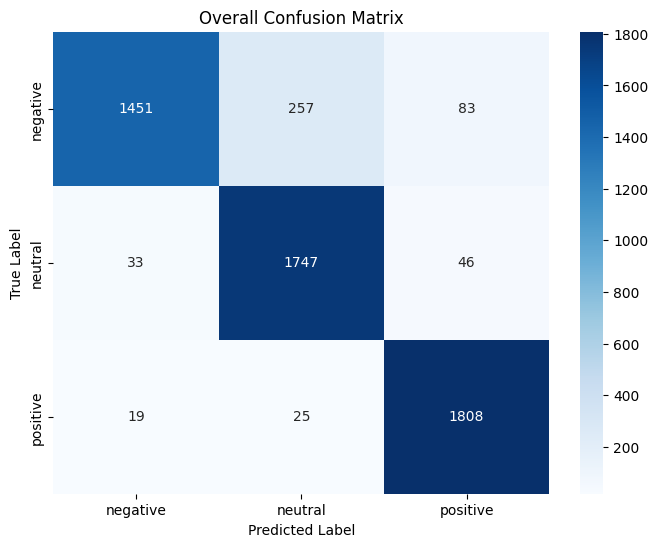

I have to admit that my last flight with Qantas airline is fabulous 😃!
1/1 [==============================] - 0s 22ms/step
The sentiment of the text is positive
How was your tirp in Sydney?
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is neutral
I should have known that the plane would be late again and again and again!!!
1/1 [==============================] - 0s 20ms/step
The sentiment of the text is negative


In [22]:
max_features = 2000
token = Tokenizer(num_words=max_features, split = ' ')
token.fit_on_texts(data['text'].values)

X = token.texts_to_sequences(data['text'].values)
X = pad_sequences(X)
Y = pd.get_dummies(data['airline_sentiment']).values

# Train Word2Vec embeddings
word2vec_embedding_dim = 128 # Set the desired embedding dimension
word2vec_model = Word2Vec(sentences=[text.split() for text in data['text'].values],
                          vector_size=word2vec_embedding_dim, window=3, min_count=1, workers=4)
# Create embedding matrix
embedding_matrix = np.zeros((max_features, word2vec_embedding_dim))
for word, i in token.word_index.items():
    if word in word2vec_model.wv and i < max_features:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture
embed_dim = word2vec_embedding_dim # Use Word2Vec embedding dimension
lstm_out = 196
batch_size = 32


# Store the scores
scores = []
accuracies = []
conf_matrices = []  # Store confusion matrices for each fold

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

model = Sequential()
model.add(Embedding(max_features, embed_dim, weights=[embedding_matrix], input_length=X.shape[1], trainable=True))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=batch_size, verbose=2,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

# Evaluate the model
score, acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=2)

# Store the score and accuracy
scores.append(score)
accuracies.append(acc)

# Predict the test data and get the confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
conf_matrices.append(conf_matrix)

# Print the average score and accuracy
print('Average score:', np.mean(scores))
print('Average accuracy:', np.mean(accuracies))

# Print confusion matrices and classification reports for each fold
for i, conf_matrix in enumerate(conf_matrices):
    print(f"Confusion Matrix (Fold {i+1}):\n{conf_matrix}\n")
    class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
    print(f"Classification Report (Fold {i+1}):\n{class_report}\n")

# Calculate and print overall confusion matrix and classification report
overall_conf_matrix = np.sum(conf_matrices, axis=0)
print("Overall Confusion Matrix:\n", overall_conf_matrix)
overall_class_report = classification_report(y_true_classes, y_pred_classes, target_names=['negative', 'neutral', 'positive'])
print("Overall Classification Report:\n", overall_class_report)

# Plot the overall confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(overall_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Overall Confusion Matrix')
plt.show()

def predict_sentiment(text):
    # Clean the text
    text = clean_train_data(text)

    # Tokenize the text
    sequences = token.texts_to_sequences([text])
    sequences = pad_sequences(sequences, maxlen=X.shape[1])

    # Predict the sentiment
    prediction = model.predict(sequences)

    # Convert the prediction into a readable form
    sentiment = np.argmax(prediction)
    sentiment_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}

    print('The sentiment of the text is', sentiment_dict[sentiment])


# Now use this function to predict the sentiment of a new text
positive_text = "I have to admit that my last flight with Qantas airline is fabulous 😃!"
neutral_text = "How was your tirp in Sydney?"
negative_text = "I should have known that the plane would be late again and again and again!!!"
print(positive_text)
predict_sentiment(positive_text)
print(neutral_text)
predict_sentiment(neutral_text)
print(negative_text)
predict_sentiment(negative_text)

#### Model performace

Based on the results shown above, it could be inferred that CNN bi-lstm model's efficiency is much better than only bi-lstm, though the average accuracy(92%) shows little difference, this model performs equally well on neutral labels' data.

1. After vector transformation, cnn is better at handling locally correlated data than bi, which requires global dependencies.
2. all computations in cnn are parallel, each convolutional kernel can be computed on all inputs at the same time.

The computation of each time step in bi depends on the hidden state of the previous time step, so it must be computed in a sequence of time steps.



### Conclusion

This comparative analysis of ML and DL methods reveals compelling insights for sentiment analysis on both binary and tri-class datasets.

1. CNN Outperforms: The results consistently demonstrate that CNN outperforms both SVM and BiLSTM in ternary sentiment data. CNN's superior capability in capturing essential text features leads to accurate sentiment predictions. Although the performance improvement in binary sentiment data is not substantial, CNN's efficiency in training makes it the preferred model, retaining its position as the better choice.

2. Optimal Use of BiLSTM and Cross-Validation: When dealing with small sample sizes of data, incorporating cross-validation proves beneficial for BiLSTM, especially in binary data scenarios. However, for large datasets, cross-validation may adversely impact accuracy due to data duplication during training, leading to increased computational demands and longer processing times.

3. Overfitting Mitigation with L2 Regularization: The usage of L2 regularization in BiLSTM effectively tackles overfitting concerns. Additionally, early stopping proves to be a valuable technique in minimizing overfitting to a certain extent.

4. BiLSTM with CNN: The BiLSTM combined with CNN emerges as the most promising training model. This architecture not only delivers impressive speed but also maximizes the extraction of crucial data features. The synergistic combination of BiLSTM and CNN contributes to overall superior performance in sentiment analysis tasks.